In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import datetime
from sklearn.preprocessing import LabelEncoder
import gc

import sklearn
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from tqdm.notebook import tqdm

#한글깨짐방지
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('Scikit-Learn : %s'%(sklearn.__version__))
!python --version

Pandas : 1.0.1
Numpy : 1.18.1
Scikit-Learn : 0.22.1
Python 3.7.6


### data

In [34]:
#데이터로드
path = './data/'
data = pd.read_csv(path +'201901-202003.csv')
submission = pd.read_csv(path + 'submission.csv')

In [4]:
data.shape, submission.shape

((24697792, 12), (1394, 5))

### 전처리

#### 결측처리

In [40]:
# 시군구 결측은 모두 세종
data.loc[data.CARD_CCG_NM.isna(),'CARD_CCG_NM'] = '세종'
data.loc[data.HOM_CCG_NM.isna(),'HOM_CCG_NM'] = '세종'

#### 날짜변환

In [41]:
data['year'] = data['REG_YYMM'].apply(lambda x : int(str(x)[:4]))
data['month'] = data['REG_YYMM'].apply(lambda x : int(str(x)[4:]))
data.drop(['REG_YYMM'],axis= 1,inplace = True)

### 추가변수

#### 18 사업체총조사

In [42]:
all_jobs_df = pd.read_csv('./data/외부데이터/18 사업체총조사_키워드매칭.csv',encoding = 'cp949')
all_jobs_df = all_jobs_df[['행정구역별','데이터업종명','사업체수 (개)', '종사자수 (명)']]
all_jobs_df.columns = ['CARD_SIDO_NM','STD_CLSS_NM', 'company','employee']
all_jobs_df.employee = all_jobs_df.employee.apply(lambda x : x.replace("X","0")).astype(int)
all_jobs_df = all_jobs_df.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])[['company','employee']].sum().reset_index()

all_jobs_df = all_jobs_df[~(all_jobs_df.CARD_SIDO_NM == '전국')]

#### 지역내 각 업종이 차지하는 매출비중

In [51]:
pp = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='month',values= "AMT",aggfunc='sum').reset_index()

In [56]:
def local_percent(data):
    sample = data[data.year == 2019]
    pivoted = sample.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='month',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    #각 지역별(시군구)업종의 매출비율을 저장
    sidos = pivoted.CARD_SIDO_NM.unique()

    local_percent_df = pd.DataFrame()
    for sido in sidos:
        sample_sido = pivoted[pivoted.CARD_SIDO_NM == sido]
        sigungus = sample_sido.CARD_CCG_NM.unique()
        for sigungu in sigungus:
            sample = sample_sido[sample_sido.CARD_CCG_NM == sigungu]
            sum_arr = sample.iloc[:,3:].sum().values.reshape(1,-1)
            parcent_df = (sample.iloc[:,3:]/sum_arr)*100

            fin = pd.concat([sample.iloc[:,:3],parcent_df],axis=1)
            local_percent_df = pd.concat([local_percent_df,fin])

    #신규변수 LP(local percent) : 지역내 각 업종이 차지하는 매출비중
    local_percent_df = local_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='LP')
    local_percent_df['month'] = local_percent_df['month'].astype(int)
    return local_percent_df

#### 전체업종에서 각 지역업종이 차지하는 매출비중

In [57]:
def job_percent(data):
    sample = data[data.year == 2019]
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='month',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    all_pivoted = sample.pivot_table(index = ['STD_CLSS_NM'],columns ='month',values= "AMT",aggfunc= 'sum').reset_index()
    all_pivoted.fillna(0,inplace= True)
    all_pivoted = all_pivoted.set_index('STD_CLSS_NM')

    job_percent_df = pd.DataFrame()
    for job in all_pivoted.index:
        taget_df = pivoted[pivoted.STD_CLSS_NM == job]
        tail = (taget_df.iloc[:,3:]/all_pivoted.iloc[0].values)*100
        head = taget_df.iloc[:,:3]
        full = pd.concat([head,tail],axis =1)
        job_percent_df = pd.concat([job_percent_df,full])

    #신규변수 JP(Job percent): 전체업종에서 해당지역의 업종이 차이하는 비율
    job_percent_df = job_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='JP')
    job_percent_df['month'] = job_percent_df['month'].astype(int)
    return job_percent_df

In [58]:
local_percent_df = local_percent(data)
job_percent_df = job_percent(data)

#### 추가변수 결합

In [60]:
data.shape

(24697792, 13)

In [61]:
grouped = pd.merge(data,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
grouped = pd.merge(grouped,local_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','month'],how = 'left')
grouped = pd.merge(grouped,job_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','month'],how = 'left')

In [62]:
grouped.shape

(24697792, 17)

In [64]:
#예측시 nan이 많이 발생할 변수를 제외 
del grouped['HOM_CCG_NM']

In [65]:
#서울중구, 대구중구 동일 지명 방지하기 위해 묶어서 인코딩 추후 split해서 병합하면됨
grouped['address'] = grouped['CARD_SIDO_NM'] +"_"+ grouped['CARD_CCG_NM']
grouped.drop(['CARD_SIDO_NM','CARD_CCG_NM'],axis=1, inplace=True)

In [66]:
grouped.head(1)

,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month,company,employee,LP,JP,address
0,건강보조식품 소매업,강원,20s,1,1,4,311200,4,2019,1,263.0,399.0,0.138432,0.585671,강원_강릉시


### 인코딩

#### 용량변환

In [67]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [68]:
#인코딩
def encoding(data):
    dtypes = grouped.dtypes
    encoders = {}
    for column in grouped.columns:
        if str(dtypes[column]) == 'object':
            encoder = LabelEncoder()
            encoder.fit(grouped[column])
            encoders[column] = encoder
    for column in encoders.keys():
        encoder = encoders[column]
        grouped[column] = encoder.transform(grouped[column])
    return encoders, data

In [69]:
encoders, grouped = encoding(grouped)

In [70]:
encoders

{'STD_CLSS_NM': LabelEncoder(),
 'HOM_SIDO_NM': LabelEncoder(),
 'AGE': LabelEncoder(),
 'address': LabelEncoder()}

In [73]:
#메모리관리
grouped = reduce_mem_usage(grouped)

del data
gc.collect()

Mem. usage decreased to 1036.36 Mb (0.0% reduction)


16198

### Model Tuning & Evaluation

In [75]:
#2019.12까지 데이터로 20.03을 예측
train_set = grouped[grouped.year == 2019]
eval_set = grouped[(grouped.year == 2020)&(grouped.month == 3)]

In [76]:
params = {'random_state': 42,
          'learning_rate': 0.01,
          'max_depth': 8,
          'num_leaves': 64,
          'boosting': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'feature_fraction': 0.9,
          'bagging_fraction': 0.7}

In [77]:
#eval, train 구성
# train_x = train_set.drop(['CSTMR_CNT','AMT','CNT'],axis= 1)
# train_y = np.log1p(train_set['AMT'])

# eval_x = eval_set.drop(['CSTMR_CNT','AMT','CNT'],axis= 1)
# eval_y = np.log1p(eval_set['AMT'])

use_col = ['STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'address', 'year', 'month', 
           'LP', 'JP','company','employee']
categorical_features = ['address','STD_CLSS_NM','HOM_SIDO_NM','SEX_CTGO_CD','AGE','FLC']

train_ds = lgb.Dataset(train_set[use_col],
                       label=np.log1p(train_set['AMT']),
                       free_raw_data=False,
                       categorical_feature=categorical_features)
eval_ds = lgb.Dataset(eval_set[use_col],
                      label=np.log1p(eval_set['AMT']),
                      free_raw_data=False,
                      categorical_feature=categorical_features)

In [85]:
evaluation_results ={}
model = lgb.train(params,train_ds,
                  num_boost_round=1000,
                  valid_sets=[train_ds, eval_ds],
                  valid_names=['Train', 'Eval'],
                  verbose_eval=500,
                  early_stopping_rounds=100, evals_result = evaluation_results)

C:\Users\kwonJH\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[500]	Train's rmse: 1.36744	Eval's rmse: 1.42257
[1000]	Train's rmse: 1.29188	Eval's rmse: 1.36335
[1500]	Train's rmse: 1.25599	Eval's rmse: 1.33274
[2000]	Train's rmse: 1.23548	Eval's rmse: 1.31751
[2500]	Train's rmse: 1.22318	Eval's rmse: 1.30897
[3000]	Train's rmse: 1.21541	Eval's rmse: 1.30398
[3500]	Train's rmse: 1.20994	Eval's rmse: 1.30063
[4000]	Train's rmse: 1.20541	Eval's rmse: 1.29785
[4500]	Train's rmse: 1.20198	Eval's rmse: 1.29588
[5000]	Train's rmse: 1.19938	Eval's rmse: 1.29446
[5500]	Train's rmse: 1.19703	Eval's rmse: 1.29322
[6000]	Train's rmse: 1.19516	Eval's rmse: 1.29225
[6500]	Train's rmse: 1.19349	Eval's rmse: 1.29148
[7000]	Train's rmse: 1.19204	Eval's rmse: 1.29095
[7500]	Train's rmse: 1.19076	Eval's rmse: 1.29062
[8000]	Train's rmse: 1.18966	Eval's rmse: 1.29023
[8500]	Train's rmse: 1.1886	Eval's rmse: 1.28966
[9000]	Train's rmse: 1.18767	Eval's rmse: 1.28926
Early stopping, best iteration is:
[8902

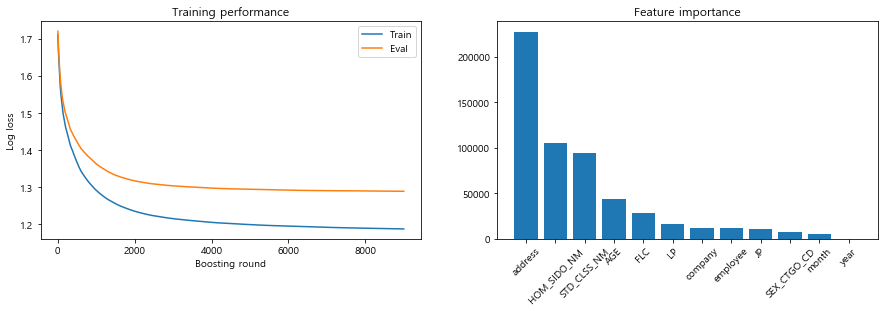

In [86]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['rmse'], label='Train')
axs[0].plot(evaluation_results['Eval']['rmse'], label='Eval')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': model.feature_name(), 
                            'importance': model.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'],rotation=45)
axs[1].set_title('Feature importance')

plt.show()

In [87]:
grouped.head(3)

,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month,company,employee,LP,JP,address
0,0,0,1,1,1,4,311200,4,2019,1,263.0,399.0,0.138428,0.585449,0
1,0,0,2,1,2,7,1374500,8,2019,1,263.0,399.0,0.138428,0.585449,0
2,0,0,2,2,2,6,818700,6,2019,1,263.0,399.0,0.138428,0.585449,0


#### 예측탬플릿만들기

In [89]:
#new(예측탬플릿), 4월 7월 나눠서 진행
def make_temp(grouped, train = True):
    addresses = grouped['address'].unique()
    STD_CLSS_NMs = grouped['STD_CLSS_NM'].unique()
    HOM_SIDO_NMs = grouped['HOM_SIDO_NM'].unique()
    AGEs = grouped['AGE'].unique()
    SEX_CTGO_CDs = grouped['SEX_CTGO_CD'].unique()
    FLCs = grouped['FLC'].unique()
    years = [2020]
    if train == True :
        months = [3]
    else :
        months = [4,7]

    temp = []
    for address in tqdm(addresses):
        for STD_CLSS_NM in STD_CLSS_NMs:
            for HOM_SIDO_NM in HOM_SIDO_NMs:
                for AGE in AGEs:
                    for SEX_CTGO_CD in SEX_CTGO_CDs:
                        for FLC in FLCs:
                            for year in years:
                                for month in months:
                                    temp.append([address, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
    temp = np.array(temp)
    temp = pd.DataFrame(data=temp, columns = ['address','STD_CLSS_NM','HOM_SIDO_NM','AGE','SEX_CTGO_CD','FLC','year','month'])
    
    #추가변수 삽입
    #변수삽입을 위한 디코더
    temp['address'] = encoders['address'].inverse_transform(temp['address'])
    temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

    temp['CARD_SIDO_NM'] = temp['address'].apply(lambda x: x.split('_')[0])
    temp['CARD_CCG_NM'] = temp['address'].apply(lambda x: x.split('_')[1])
    temp['REG_YYMM'] = temp['year']*100 +temp['month']

    temp = pd.merge(temp,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
    temp = pd.merge(temp,local_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','month'],how = 'left')
    temp = pd.merge(temp,job_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','month'],how = 'left')

    temp['address'] = encoders['address'].transform(temp['address'])
    temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].transform(temp['STD_CLSS_NM'])
    temp.drop(['CARD_SIDO_NM','CARD_CCG_NM'],axis = 1,inplace = True)
    
    return temp

In [90]:
 temp = make_temp(grouped, train = True)

In [91]:
temp

,address,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,REG_YYMM,company,employee,LP,JP
0,0,0,0,1,1,1,2020,3,202003,263.0,399.0,0.127142,0.575793
1,0,0,0,1,1,2,2020,3,202003,263.0,399.0,0.127142,0.575793
2,0,0,0,1,1,3,2020,3,202003,263.0,399.0,0.127142,0.575793
3,0,0,0,1,1,4,2020,3,202003,263.0,399.0,0.127142,0.575793
4,0,0,0,1,1,5,2020,3,202003,263.0,399.0,0.127142,0.575793
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12197495,249,30,14,0,2,1,2020,3,202003,6.0,57.0,NaN,NaN
12197496,249,30,14,0,2,2,2020,3,202003,6.0,57.0,NaN,NaN
12197497,249,30,14,0,2,3,2020,3,202003,6.0,57.0,NaN,NaN
12197498,249,30,14,0,2,4,2020,3,202003,6.0,57.0,NaN,NaN


In [96]:
grouped[(grouped.address ==249)&(grouped.STD_CLSS_NM == 30)]

,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month,company,employee,LP,JP,address


#### predict

In [ ]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)

### 예측결과 담기

In [ ]:
temp['address'] = encoders['address'].inverse_transform(temp['address'])
temp['AMT'] = np.round(pred,0)
temp['REG_YYMM'] = temp['year']*100 +temp['month']
temp['CARD_SIDO_NM'] = temp['address'].apply(lambda x: x.split('_')[0])
temp['CARD_CCG_NM'] = temp['address'].apply(lambda x: x.split('_')[1])

temp = temp[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]
temp = temp.groupby(['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM']).sum().reset_index(drop=False)

In [ ]:
#비교군
eval_set['address'] = encoders['address'].inverse_transform(eval_set['address'])
eval_set['REG_YYMM'] = eval_set['year'].astype('int64')*100 +eval_set['month']
eval_set['CARD_SIDO_NM'] = eval_set['address'].apply(lambda x: x.split('_')[0])
eval_set['CARD_CCG_NM'] = eval_set['address'].apply(lambda x: x.split('_')[1])

eval_set = eval_set[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]
eval_set = eval_set.groupby(['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM']).sum().reset_index(drop=False)

In [ ]:
eval_set.columns = ['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT_answer']
temp = pd.merge(temp,eval_set,how = 'left')
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])
temp

In [ ]:
#강원 정기 항공 운송업,면세점은 데이터로 보유하고 있지 않음. 근데 높게 예측 
#3다른 날에는 매출이 있으나, 2020년 3월에 데이터가 없는 경우 검증이 어려움...
temp.loc[temp.AMT_answer.isna()]
# temp.loc[temp.AMT_answer.isna()].to_csv('./insight/없는없종na로라도 넣어봄.csv')

In [110]:
#제출파일과 비교
check_df = pd.merge(temp,all_jobs_df,left_on=['CARD_SIDO_NM','STD_CLSS_NM'],right_on=['CARD_SIDO_NM','STD_CLSS_NM'],how='left')

In [116]:
check_df[check_df.company.isna()]

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT,AMT_answer,company,employee
137,202003,경북,면세점,883408584.0,NaN,NaN,NaN
176,202003,광주,내항 여객 운송업,193192364.0,NaN,NaN,NaN
178,202003,광주,면세점,184043455.0,NaN,NaN,NaN
204,202003,광주,휴양콘도 운영업,138939800.0,NaN,NaN,NaN
217,202003,대구,내항 여객 운송업,306863880.0,NaN,NaN,NaN
245,202003,대구,휴양콘도 운영업,222303680.0,NaN,NaN,NaN
258,202003,대전,내항 여객 운송업,191789925.0,NaN,NaN,NaN
377,202003,세종,기타 수상오락 서비스업,35579811.0,NaN,NaN,NaN
381,202003,세종,내항 여객 운송업,38357985.0,NaN,NaN,NaN
383,202003,세종,면세점,36808691.0,NaN,NaN,NaN


In [117]:
del pred, train_set, eval_set

gc.collect()

### predict

In [118]:
#train to private (4월예측모델)
#20년 1월까지 데이터만 사용
p_train = pd.concat([grouped[grouped.year == 2019],grouped[(grouped.year == 2020)&(grouped.month == 1)]])

In [121]:
# Feature, taget 설정
# train_features = p_train.drop(['CSTMR_CNT','AMT','CNT'],axis= 1)
train_target = np.log1p(p_train['AMT'])

In [122]:
train_ds = lgb.Dataset(p_train[use_col],label=train_target)
model = lgb.train(params,train_ds,num_boost_round=1000)

In [131]:
del p_train

In [ ]:
grouped

In [134]:
#new(예측탬플릿)
addresses = grouped['address'].unique()
STD_CLSS_NMs = grouped['STD_CLSS_NM'].unique()
HOM_SIDO_NMs = grouped['HOM_SIDO_NM'].unique()
AGEs = grouped['AGE'].unique()
SEX_CTGO_CDs = grouped['SEX_CTGO_CD'].unique()
FLCs = grouped['FLC'].unique()
years = [2020]
months = [4,7 ]

temp = []
for address in tqdm(addresses):
    for STD_CLSS_NM in STD_CLSS_NMs:
        for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    for FLC in FLCs:
                        for year in years:
                            for month in months:
                                temp.append([address, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns = ['address','STD_CLSS_NM','HOM_SIDO_NM','AGE','SEX_CTGO_CD','FLC','year','month'])

MemoryError: 

#### 추가변수준비

In [ ]:
temp

In [133]:
#변수삽입을 위한 디코더
temp['address'] = encoders['address'].inverse_transform(temp['address'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

temp['CARD_SIDO_NM'] = temp['address'].apply(lambda x: x.split('_')[0])
temp['CARD_CCG_NM'] = temp['address'].apply(lambda x: x.split('_')[1])
temp['REG_YYMM'] = temp['year']*100 +temp['month']

temp = pd.merge(temp,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
temp = pd.merge(temp,local_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')
temp = pd.merge(temp,job_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')

temp['address'] = encoders['address'].transform(temp['address'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].transform(temp['STD_CLSS_NM'])
temp.drop(['CARD_SIDO_NM','CARD_CCG_NM','REG_YYMM'],axis = 1,inplace = True)

MemoryError: Unable to allocate 372. MiB for an array with shape (24395000,) and data type complex128

In [ ]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)

In [ ]:
temp['address'] = encoders['address'].inverse_transform(temp['address'])
temp['AMT'] = np.round(pred,0)
temp['REG_YYMM'] = temp['year']*100 +temp['month']
temp['CARD_SIDO_NM'] = temp['address'].apply(lambda x: x.split('_')[0])
temp['CARD_CCG_NM'] = temp['address'].apply(lambda x: x.split('_')[1])

temp = temp[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]
temp = temp.groupby(['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM']).sum().reset_index(drop=False)

#### 후처리

In [ ]:
#18년 사업체총조사 기준, 그 지역에 없는 업종은 0처리 
temp = pd.merge(temp,all_jobs_df,left_on=['CARD_SIDO_NM','STD_CLSS_NM'],right_on=['CARD_SIDO_NM','STD_CLSS_NM'],how='left')
temp.loc[temp.company.isna(),'AMT'] = 0

In [ ]:
#제출파일
submission = pd.read_csv('data/submission.csv',index_col=0)
submission = submission.drop(['AMT'],axis= 1)
submission = submission.merge(temp, left_on=['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'],right_on =['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
submission.index.name = 'id'